In [ ]:
# Get Data
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

#Unzip data
zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip", 'r')
zip_ref.extractall()
zip_ref.close()

--2023-12-08 02:30:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  19.9MB/s    in 84s     

2023-12-08 02:31:27 (18.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
import os
for dirpath, dirnames, filenames in os.walk('101_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 101_food_classes_10_percent
There are 101 directories and 0 images in 101_food_classes_10_percent/test
There are 0 directories and 250 images in 101_food_classes_10_percent/test/prime_rib
There are 0 directories and 250 images in 101_food_classes_10_percent/test/french_fries
There are 0 directories and 250 images in 101_food_classes_10_percent/test/onion_rings
There are 0 directories and 250 images in 101_food_classes_10_percent/test/club_sandwich
There are 0 directories and 250 images in 101_food_classes_10_percent/test/fish_and_chips
There are 0 directories and 250 images in 101_food_classes_10_percent/test/mussels
There are 0 directories and 250 images in 101_food_classes_10_percent/test/carrot_cake
There are 0 directories and 250 images in 101_food_classes_10_percent/test/bibimbap
There are 0 directories and 250 images in 101_food_classes_10_percent/test/baklava
There are 0 directories and 250 images in 101_food_classes_10_percent/test/chocol

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')
  print(f'image shape : {img.shape}')
  return img

image shape : (512, 512, 3)


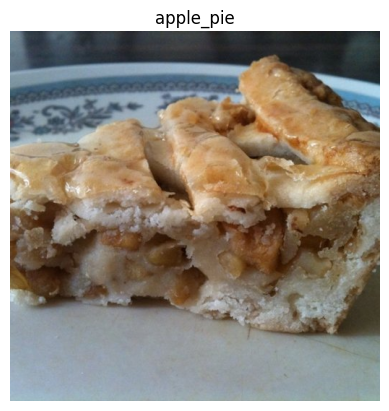

In [ ]:
img = view_random_image(target_dir = '101_food_classes_10_percent/train/', target_class='apple_pie')

In [ ]:
#create training and test directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode='categorical',
                                                                 batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=32,
                                                                shuffle=False)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
#create tensorboard callback
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving Tensorboard log files to: {log_dir}')
  return tensorboard_callback

In [ ]:
initial_epochs=5
#create base model with efficientnet
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
#Freeze the base model
base_model.trainable = False
#create input into the base model
input = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')
#pass the input to the base model
x = base_model(input)
#average pool the outputs of the best model
x = tf.keras.layers.GlobalAveragePooling2D(name='golbal_average_pooling_layers')(x)
#create the output activation layers
output = tf.keras.layers.Dense((len(train_data.class_names)), activation='softmax', name='output_layers')(x)
#combine the input and output into a model
model_food = tf.keras.Model(input, output)
#compile the model
model_food.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['accuracy'])
checkpoint_path = 'model_food_weights/checkpoint.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weight_only=True,
                                                         save_best_only=False,
                                                         save_freq = 'epoch',
                                                         verbose=1)
history_model = model_food.fit(train_data,
                               epochs = initial_epochs,
                               steps_per_epoch = len(train_data),
                               validation_data = test_data,
                               validation_steps = int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback('transer_learning', '101_food_classes'),
                                          checkpoint_callback])

24274472/24274472 [==============================] - 2s 0us/step
Saving Tensorboard log files to: transer_learning/101_food_classes/20231208-023200
Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.2035 - accuracy: 0.3155
Epoch 1: saving model to model_food_weights/checkpoint.ckpt
237/237 [==============================] - 78s 258ms/step - loss: 3.2035 - accuracy: 0.3155 - val_loss: 2.4479 - val_accuracy: 0.4423
Epoch 2/5
236/237 [============================>.] - ETA: 0s - loss: 1.9522 - accuracy: 0.5632
Epoch 2: saving model to model_food_weights/checkpoint.ckpt
237/237 [==============================] - 67s 283ms/step - loss: 1.9504 - accuracy: 0.5637 - val_loss: 1.9638 - val_accuracy: 0.5219
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.5522 - accuracy: 0.6368
Epoch 3: saving model to model_food_weights/checkpoint.ckpt
237/237 [==============================] - 67s 281ms/step - loss: 1.5522 - accuracy: 0.6368 - val_loss: 1.7878 - val_ac

In [ ]:
result_model_food = model_food.evaluate(test_data)
result_model_food

790/790 [==============================] - 57s 72ms/step - loss: 1.4609 - accuracy: 0.6198


[1.4608598947525024, 0.6198415756225586]

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))
  #plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('Epochs')
  plt.legend()
  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

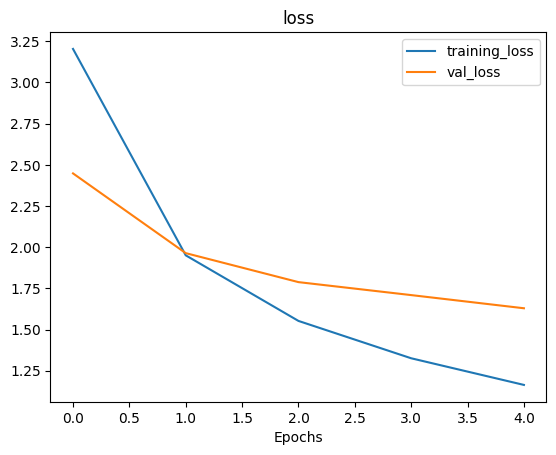

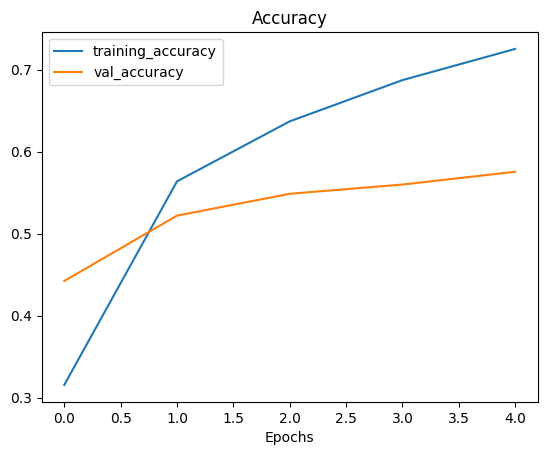

In [ ]:
plot_loss_curves(history_model)

In [ ]:
# create model 2 with data augmentation
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name='data_augmentation')
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable=False
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layers')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layers')(x)
outputs = tf.keras.layers.Dense((len(train_data.class_names)), activation='softmax', name='output_layers')(x)
model_food_augmentation = tf.keras.Model(inputs,outputs)
model_food_augmentation.compile(loss='categorical_crossentropy',
                                optimizer = tf.keras.optimizers.Adam(),
                                metrics=['accuracy'])
history_model_augmentation = model_food_augmentation.fit(train_data,
                                                         epochs = initial_epochs,
                                                         steps_per_epoch = len(train_data),
                                                         validation_data = test_data,
                                                         validation_steps = int(0.25*len(test_data)),
                                                         callbacks = [create_tensorboard_callback('transer_learning', 'model_augmentation')])

Saving Tensorboard log files to: transer_learning/model_augmentation/20231208-023904
Epoch 1/5
237/237 [==============================] - 131s 514ms/step - loss: 3.5099 - accuracy: 0.2415 - val_loss: 2.6810 - val_accuracy: 0.3932
Epoch 2/5
237/237 [==============================] - 88s 368ms/step - loss: 2.4201 - accuracy: 0.4503 - val_loss: 2.2056 - val_accuracy: 0.4629
Epoch 3/5
237/237 [==============================] - 75s 313ms/step - loss: 2.0484 - accuracy: 0.5178 - val_loss: 2.0087 - val_accuracy: 0.4933
Epoch 4/5
237/237 [==============================] - 72s 300ms/step - loss: 1.8411 - accuracy: 0.5517 - val_loss: 1.8963 - val_accuracy: 0.5124
Epoch 5/5
237/237 [==============================] - 63s 265ms/step - loss: 1.6904 - accuracy: 0.5805 - val_loss: 1.8213 - val_accuracy: 0.5286


In [ ]:
result_model_augmentation = model_food_augmentation.evaluate(test_data)
result_model_augmentation

790/790 [==============================] - 64s 81ms/step - loss: 1.6182 - accuracy: 0.5767


[1.6182117462158203, 0.5767128467559814]

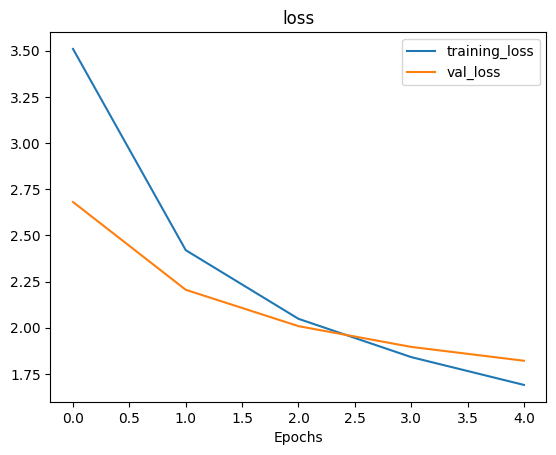

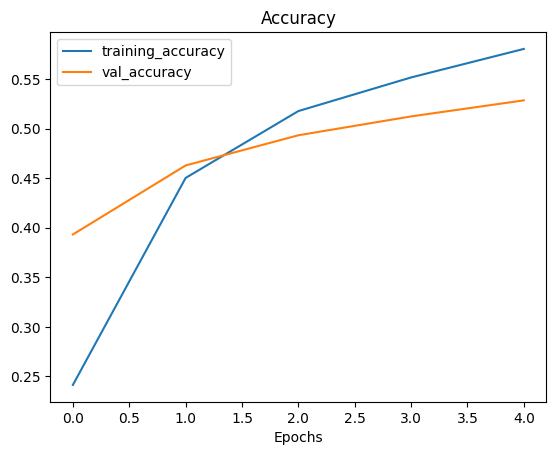

In [ ]:
plot_loss_curves(history_model_augmentation)

In [ ]:
#Fine Tuning Model
model_food.load_weights(checkpoint_path)
loaded_weight_model_results = model_food.evaluate(test_data)

790/790 [==============================] - 60s 76ms/step - loss: 1.4609 - accuracy: 0.6198


In [ ]:
model_food.layers

In [ ]:
for layer_number, layer in enumerate(model_food.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.src.engine.input_layer.InputLayer object at 0x7b138c4bb940> | Trainable? True
Layer number: 1 | Layer name: efficientnetv2-b0 | Layer type: <keras.src.engine.functional.Functional object at 0x7b13882eda80> | Trainable? False
Layer number: 2 | Layer name: golbal_average_pooling_layers | Layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7b138841c610> | Trainable? True
Layer number: 3 | Layer name: output_layers | Layer type: <keras.src.layers.core.dense.Dense object at 0x7b138825bb80> | Trainable? True


In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False
model_food.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   metrics=['accuracy'])
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
fine_tune_epochs = initial_epochs + 5
history_model_fine_tune = model_food.fit(train_data,
                                             epochs=fine_tune_epochs,
                                             validation_data=test_data,
                                             initial_epoch = history_model.epoch[-1],
                                             validation_steps = int(0.25*len(test_data)),
                                             callbacks = [create_tensorboard_callback('transer_learning', 'fine_tune_model')])

Saving Tensorboard log files to: transer_learning/fine_tune_model/20231208-024837
Epoch 5/10
237/237 [==============================] - 40s 131ms/step - loss: 1.0032 - accuracy: 0.7768 - val_loss: 1.6203 - val_accuracy: 0.5830
Epoch 6/10
237/237 [==============================] - 31s 130ms/step - loss: 0.9791 - accuracy: 0.7846 - val_loss: 1.6158 - val_accuracy: 0.5842
Epoch 7/10
237/237 [==============================] - 30s 124ms/step - loss: 0.9700 - accuracy: 0.7868 - val_loss: 1.6165 - val_accuracy: 0.5828
Epoch 8/10
237/237 [==============================] - 38s 160ms/step - loss: 0.9614 - accuracy: 0.7892 - val_loss: 1.6094 - val_accuracy: 0.5852
Epoch 9/10
237/237 [==============================] - 37s 157ms/step - loss: 0.9332 - accuracy: 0.8025 - val_loss: 1.6061 - val_accuracy: 0.5858
Epoch 10/10
237/237 [==============================] - 37s 157ms/step - loss: 0.9316 - accuracy: 0.7978 - val_loss: 1.6052 - val_accuracy: 0.5839


In [ ]:
result_fine_tuning = model_food.evaluate(test_data)

790/790 [==============================] - 58s 73ms/step - loss: 1.4065 - accuracy: 0.6362


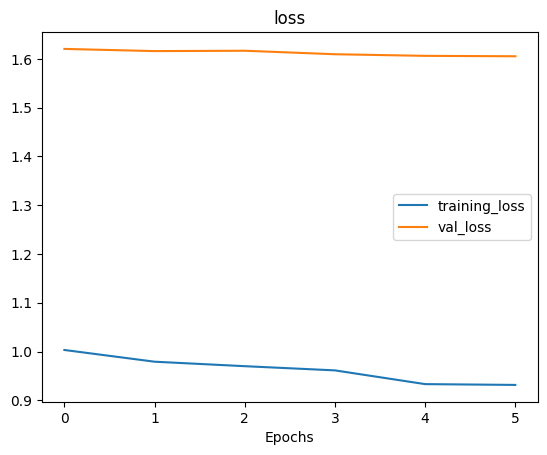

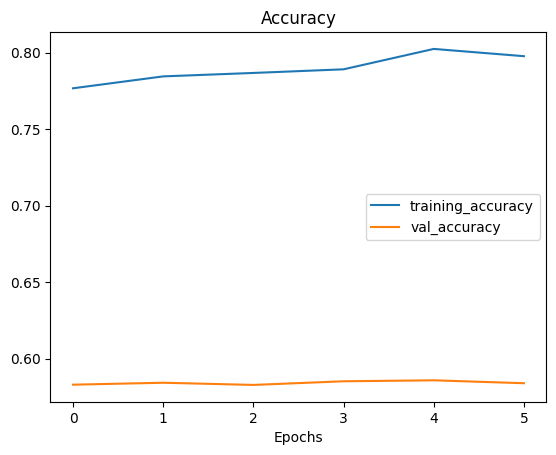

In [ ]:
plot_loss_curves(history_model_fine_tune)

In [ ]:
def compare_history(original_history, new_history, initial_epochs=5):
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']
  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  total_acc = acc+new_history.history['accuracy']
  total_loss = loss+new_history.history['loss']
  total_vall_acc = val_acc+new_history.history['val_accuracy']
  total_vall_loss = val_loss+new_history.history['val_loss']

  plt.figure(figsize=(8,9))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_vall_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training & Validation Accuracy')

  plt.subplot(2,1,2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_vall_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training & Validation Loss')
  plt.xlabel('epoch')
  plt.show()

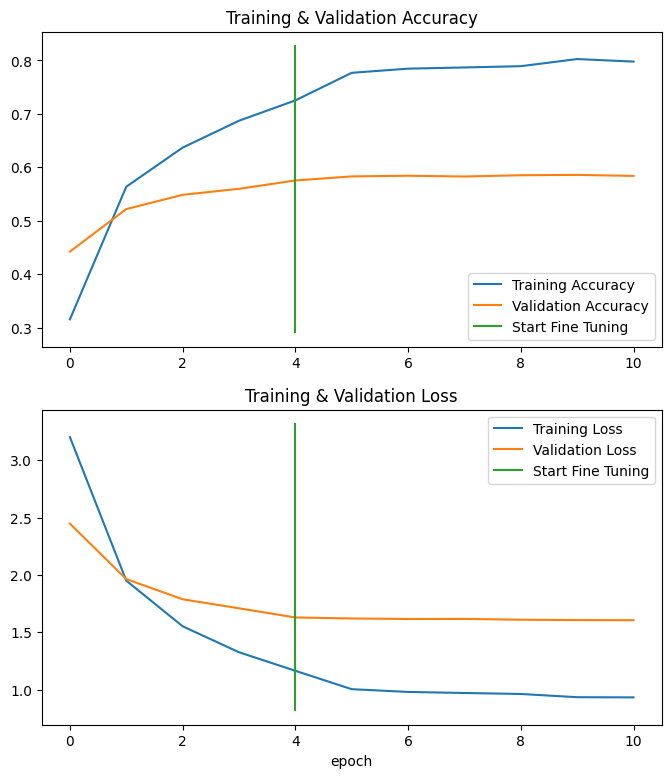

In [ ]:
compare_history(history_model, history_model_fine_tune, initial_epochs=5)

Based on the results of fine tuning which is overfitting, we reuse the model that has not been fine tuned

In [ ]:
model_food.load_weights(checkpoint_path)
for layer_number, layer in enumerate(model_food.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 efficientnetv2-b0 False
2 golbal_average_pooling_layers True
3 output_layers True


In [ ]:
pred_probs = model_food.predict(test_data, verbose=1)
pred_probs[:-10]

790/790 [==============================] - 59s 72ms/step


array([[3.63072753e-03, 2.32504084e-04, 3.46209794e-01, ...,
        5.68832638e-06, 2.39276234e-03, 2.39774439e-04],
       [4.78436559e-01, 5.36439302e-06, 1.47002507e-02, ...,
        3.65436636e-03, 2.30164223e-05, 4.57788818e-04],
       [1.88116983e-01, 1.43420219e-03, 3.63229588e-02, ...,
        3.33603541e-03, 3.77719261e-04, 3.21574789e-03],
       ...,
       [2.48330627e-02, 3.13322544e-02, 1.49876187e-02, ...,
        2.81330850e-02, 2.37880129e-04, 1.80813596e-02],
       [1.22673504e-01, 1.85611576e-03, 8.75276253e-02, ...,
        1.10228255e-03, 4.42262739e-04, 4.23891783e-01],
       [7.02257920e-03, 1.39464252e-03, 4.68214229e-02, ...,
        1.47633255e-03, 3.68483667e-03, 4.95467111e-02]], dtype=float32)

In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:-10]

array([  2,   0,   0, ...,  52, 100,  42])

In [ ]:
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [ ]:
#evaluating Our Model Predictions
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6198415841584158

In [ ]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
#Make a Classification Matrix
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

In [ ]:
make_confusion_matrix(y_labels, pred_classes, figsize=(100,100),
                      text_size=20, classes=class_names)

In [ ]:
from sklearn.metrics import classification_report
classification_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_dict

{'0': {'precision': 0.4090909090909091,
  'recall': 0.288,
  'f1-score': 0.3380281690140845,
  'support': 250},
 '1': {'precision': 0.6229508196721312,
  'recall': 0.608,
  'f1-score': 0.6153846153846155,
  'support': 250},
 '2': {'precision': 0.5,
  'recall': 0.684,
  'f1-score': 0.5777027027027026,
  'support': 250},
 '3': {'precision': 0.6185185185185185,
  'recall': 0.668,
  'f1-score': 0.6423076923076924,
  'support': 250},
 '4': {'precision': 0.6077348066298343,
  'recall': 0.44,
  'f1-score': 0.5104408352668214,
  'support': 250},
 '5': {'precision': 0.4911504424778761,
  'recall': 0.444,
  'f1-score': 0.46638655462184875,
  'support': 250},
 '6': {'precision': 0.7782258064516129,
  'recall': 0.772,
  'f1-score': 0.7751004016064257,
  'support': 250},
 '7': {'precision': 0.8632075471698113,
  'recall': 0.732,
  'f1-score': 0.7922077922077922,
  'support': 250},
 '8': {'precision': 0.3108433734939759,
  'recall': 0.516,
  'f1-score': 0.3879699248120301,
  'support': 250},
 '9': {

1. Precision - Proportion of true positives over total number of samples.
Higher precision leads to less false positives (model predicts 1 when it should've been 0).
2. Recall - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
3. F1 score - Combines precision and recall into one metric. 1 is best, 0 is worst

In [ ]:
class_f1_scores = {}
for k, v in classification_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]]=v['f1-score']
class_f1_scores

{'apple_pie': 0.3380281690140845,
 'baby_back_ribs': 0.6153846153846155,
 'baklava': 0.5777027027027026,
 'beef_carpaccio': 0.6423076923076924,
 'beef_tartare': 0.5104408352668214,
 'beet_salad': 0.46638655462184875,
 'beignets': 0.7751004016064257,
 'bibimbap': 0.7922077922077922,
 'bread_pudding': 0.3879699248120301,
 'breakfast_burrito': 0.6109979633401221,
 'bruschetta': 0.5048169556840078,
 'caesar_salad': 0.6182432432432433,
 'cannoli': 0.6709401709401709,
 'caprese_salad': 0.5657015590200445,
 'carrot_cake': 0.5532879818594104,
 'ceviche': 0.3603603603603604,
 'cheese_plate': 0.6551059730250481,
 'cheesecake': 0.3944954128440367,
 'chicken_curry': 0.46354166666666663,
 'chicken_quesadilla': 0.659217877094972,
 'chicken_wings': 0.7076350093109869,
 'chocolate_cake': 0.550098231827112,
 'chocolate_mousse': 0.3824959481361426,
 'churros': 0.7451820128479656,
 'clam_chowder': 0.7150259067357513,
 'club_sandwich': 0.6820809248554913,
 'crab_cakes': 0.45483870967741935,
 'creme_brulee

In [ ]:
import pandas as pd
f1_scores = pd.DataFrame({'class_name':list(class_f1_scores.keys()),
                          'f1-scores':list(class_f1_scores.values())}).sort_values('f1-scores', ascending=False)
f1_scores.head()

class_name  f1-scores
33    edamame   0.968254
63   macarons   0.909091
69    oysters   0.867220
32  dumplings   0.864198
75        pho   0.843691

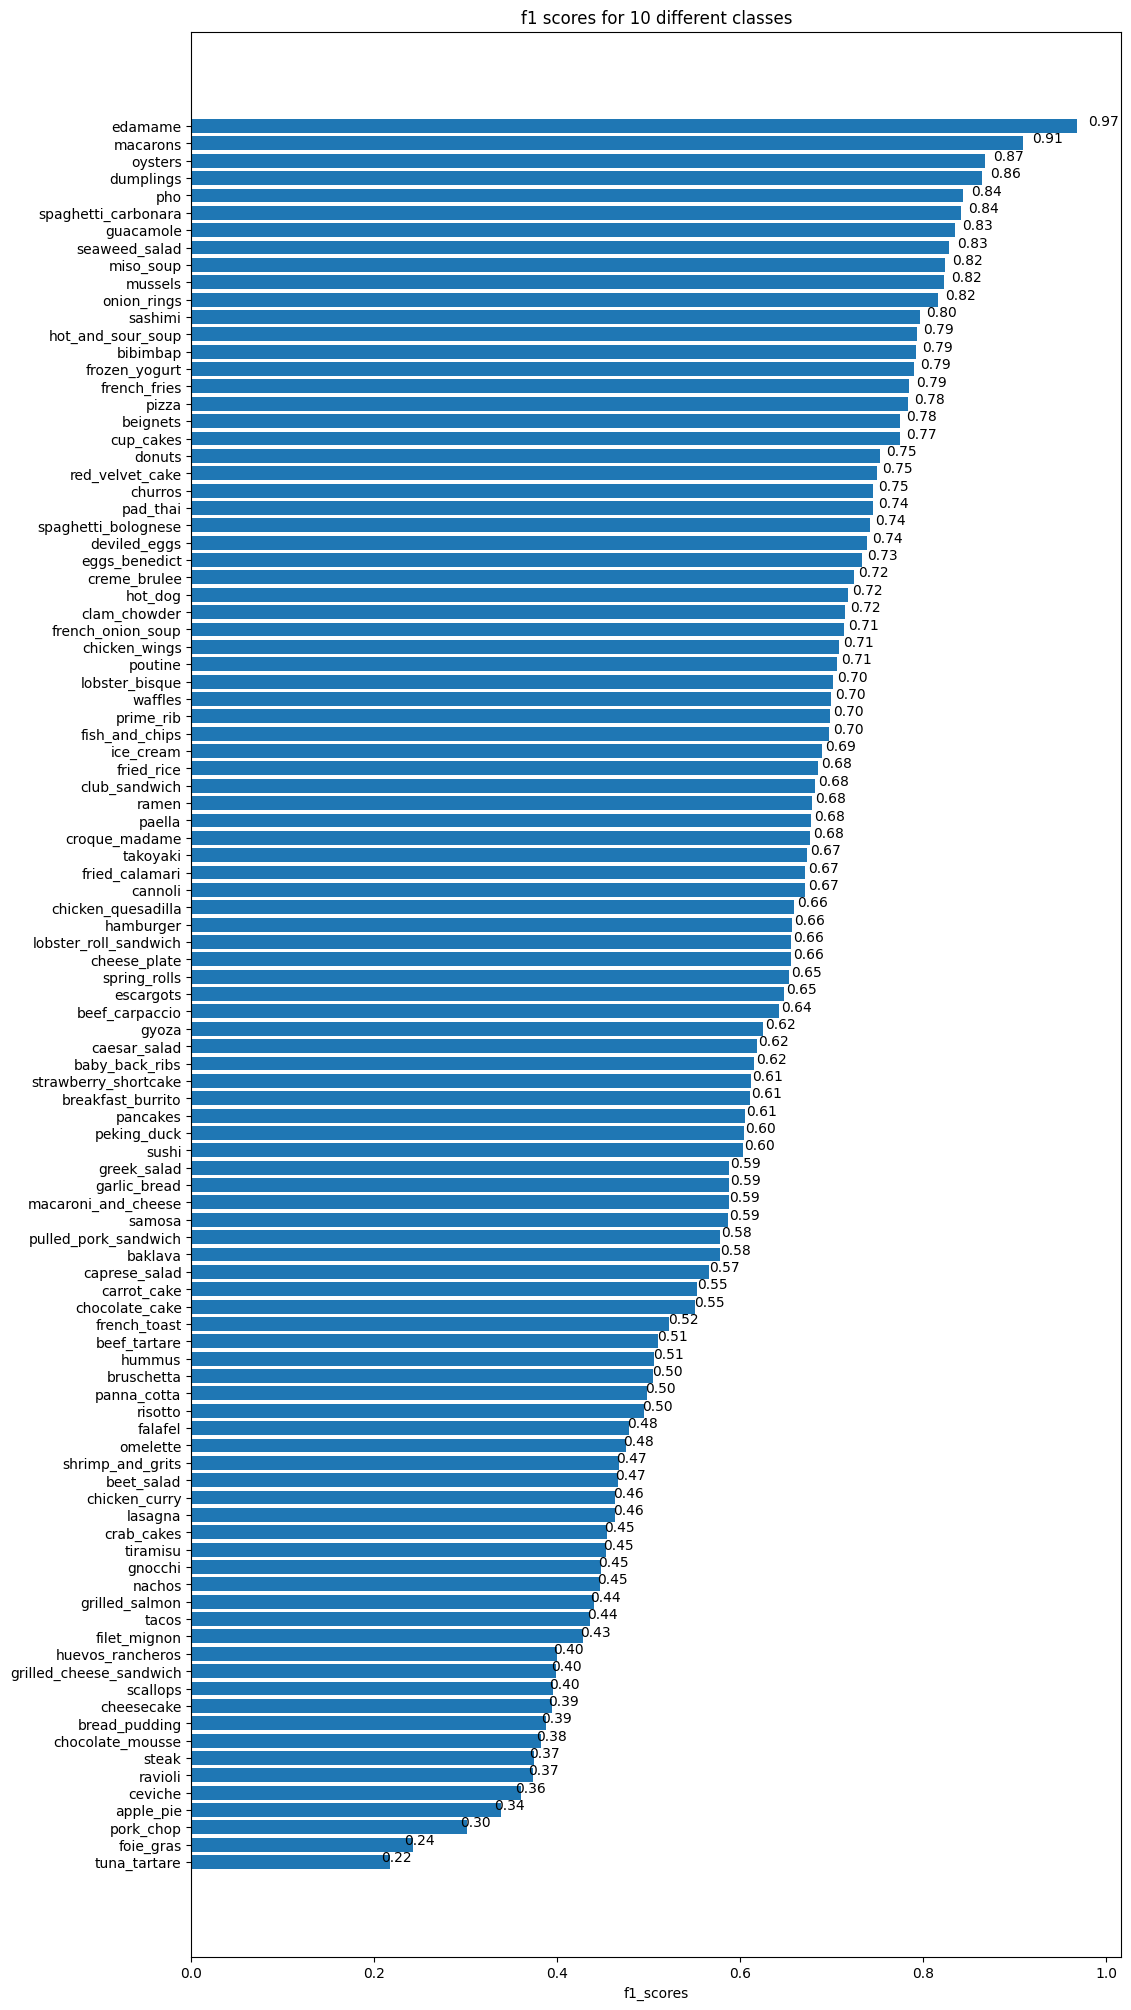

In [ ]:
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-scores'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores['class_name']))
ax.set_xlabel('f1_scores')
ax.set_title('f1 scores for 10 different classes')
ax.invert_yaxis();

def autolabel(rects):
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y()+rect.get_height()/1.5,
           f"{width:.2f}",
           ha='center', va='bottom')
autolabel(scores)

In [ ]:
#Load and Pred Image
def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size=[img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 93ms/step


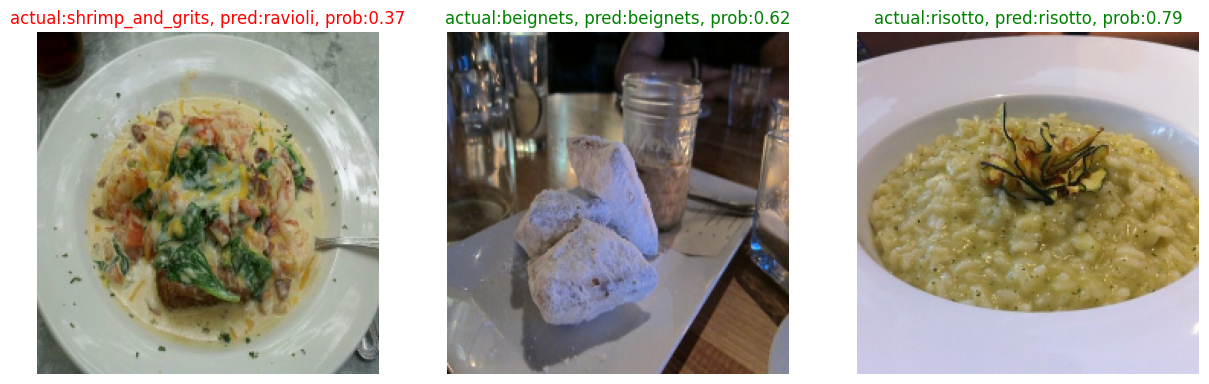

In [ ]:
# Make preds on a series of random images
import random
plt.figure(figsize=(15,15))
for i in range (3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name))
  filepath = test_dir + class_name + '/' + filename
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model_food.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1,3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f'actual:{class_name}, pred:{pred_class}, prob:{pred_prob.max():.2f}', c=title_color)
  plt.axis(False)

In this session we will collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

In [ ]:
#Finding the most wrong prediction
filepaths = []
for filepath in test_data.list_files('101_food_classes_10_percent/test/*/*.jpg',
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [52]:
import pandas as pd
pred_df = pd.DataFrame({'img_path':filepaths,
                        'y_true': y_labels,
                        'y_pred': pred_classes,
                        'pred_conf':pred_probs.max(axis=1),
                        'y_true_classname':[class_names[i] for i in y_labels],
                        'y_pred_classname':[class_names[i] for i in pred_classes]})
pred_df.head(10)

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       2   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
5  b'101_food_classes_10_percent/test/apple_pie/1...       0      78   
6  b'101_food_classes_10_percent/test/apple_pie/1...       0      29   
7  b'101_food_classes_10_percent/test/apple_pie/1...       0      46   
8  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
9  b'101_food_classes_10_percent/test/apple_pie/1...       0      41   

   pred_conf y_true_classname   y_pred_classname  
0   0.346210        apple_pie            baklava  
1   0.478437        apple_pie          apple_pie  
2   0.188117        apple_pie          apple_pie  
3   0.351739        apple_pie          apple_pie  
4   0.425727        apple_pie      bread_pudding  
5   0.654506        apple_pie            poutine  
6   0.223080        apple_pie          cup_cakes  
7   0.383298        apple_pie       garlic_bread  
8   0.216776        apple_pie          apple_pie  
9   0.413212        apple_pie  french_onion_soup

In [53]:
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       2   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.346210        apple_pie          baklava         False  
1   0.478437        apple_pie        apple_pie          True  
2   0.188117        apple_pie        apple_pie          True  
3   0.351739        apple_pie        apple_pie          True  
4   0.425727        apple_pie    bread_pudding         False

In [54]:
#get the 50 wrong examples
top_50_wrong = pred_df[pred_df['pred_correct']==False].sort_values('pred_conf', ascending=False)[:50]
top_50_wrong.head(20)

img_path  y_true  y_pred  \
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
5448   b'101_food_classes_10_percent/test/chocolate_c...      21      22   
5398   b'101_food_classes_10_percent/test/chocolate_c...      21      22   
8982   b'101_food_classes_10_percent/test/escargots/7...      35      31   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
21652  b'101_food_classes_10_percent/test/sashimi/306...      86      95   
14482  b'101_food_classes_10_percent/test/hummus/8476...      57      51   
3779   b'101_food_classes_10_percent/test/ceviche/149...      15      48   
2310   b'101_food_classes_10_percent/test/breakfast_b...       9      92   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
17908  b'101_food_classes_10_percent/test/paella/3192...      71      65   
22044  b'101_food_classes_10_percent/test/seaweed_sal...      88       5   
20478  b'101_food_classes_10_percent/test/ramen/71449...      81      75   
14375  b'101_food_classes_10_percent/test/hummus/2976...      57      27   
7267   b'101_food_classes_10_percent/test/cup_cakes/1...      29      83   
9559   b'101_food_classes_10_percent/test/fish_and_ch...      38      43   
14989  b'101_food_classes_10_percent/test/lasagna/816...      59      76   
18285  b'101_food_classes_10_percent/test/panna_cotta...      73      22   
23992  b'101_food_classes_10_percent/test/sushi/91371...      95      86   
7942   b'101_food_classes_10_percent/test/donuts/3828...      31       6   

       pred_conf   y_true_classname  y_pred_classname  pred_correct  
23797   0.980731              sushi           sashimi         False  
5448    0.967974     chocolate_cake  chocolate_mousse         False  
5398    0.966382     chocolate_cake  chocolate_mousse         False  
8982    0.961863          escargots            donuts         False  
18001   0.957927           pancakes          omelette         False  
21652   0.948631            sashimi             sushi         False  
14482   0.942557             hummus         guacamole         False  
3779    0.939702            ceviche       greek_salad         False  
2310    0.936225  breakfast_burrito      spring_rolls         False  
21400   0.936012             samosa      spring_rolls         False  
17908   0.934754             paella           mussels         False  
22044   0.931700      seaweed_salad        beet_salad         False  
20478   0.929913              ramen               pho         False  
14375   0.929334             hummus      creme_brulee         False  
7267    0.925502          cup_cakes   red_velvet_cake         False  
9559    0.924687     fish_and_chips    fried_calamari         False  
14989   0.917646            lasagna             pizza         False  
18285   0.917382        panna_cotta  chocolate_mousse         False  
23992   0.915370              sushi           sashimi         False  
7942    0.913423             donuts          beignets         False

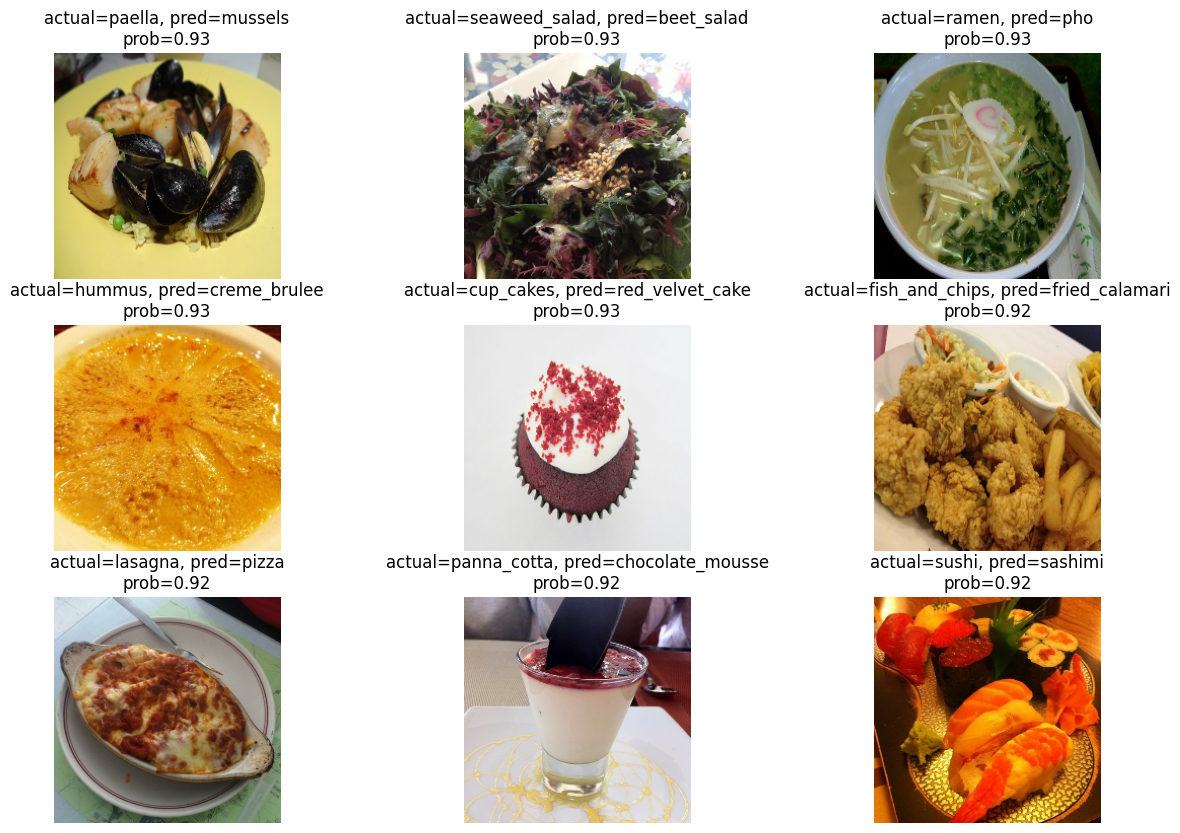

In [57]:
images_to_view = 9
start_index = 10
plt.figure(figsize=(15,10))
for i, row in enumerate(top_50_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img=load_and_prep_image(row[1], scale=True)
  _,_,_,_,pred_prob,y_true,y_pred,_ = row
  plt.imshow(img)
  plt.title(f'actual={y_true}, pred={y_pred}\nprob={pred_prob:.2f}')
  plt.axis(False)

It can be seen that our model difficult to distinguish foods that look almost the same as sushi and sashimi, then cup cake and red velvet, and the lasagna and pizza